In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from matplotlib.lines import Line2D
import ast

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [72]:
condition_map = utils.get_nudge_condition_map()
nudge_conditions = condition_map.values()

exp_measures = pd.read_csv("data/measures.csv")
exp_measures["a_values"] = exp_measures.a_condition.apply(ast.literal_eval).apply(tuple).apply(str)
exp_measures["nudge_condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

In [88]:
def plot_var_by_condition(exp_measures, model_measures, var, model_label, include_model=True, include_legend=False):
    tta_conditions = [4.5, 5.5]
    d_condition = 80
    markers=["o", "s"]
    colors = ["C0", "C1"]

    fig, ax = plt.subplots(1, 1, figsize=(3,3), sharex=True, sharey=True)
    # ax = axes[0]
    # for tta, ax in zip([4.5, 5.5], axes):
    for tta, color, marker in zip(tta_conditions, colors, markers):
        exp_measures_by_nudge_condition = exp_measures[(exp_measures.tta_condition == tta)]
        model_measures_by_nudge_condition = model_measures[(model_measures.tta_0==tta) & (model_measures.d_0==d_condition)].sort_values("nudge_condition")

        if var == "is_go_decision":
            psf_ci = utils.get_psf_ci(exp_measures_by_nudge_condition)
            ax.plot(psf_ci.nudge_condition, psf_ci.p_go, ls="", marker=marker, ms=9, color=color, zorder=10)
            ax.vlines(x=psf_ci.nudge_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
            if include_model:
                ax.plot(model_measures_by_nudge_condition.nudge_condition, model_measures_by_nudge_condition.is_gap_accepted, color=color, label=tta)
            ax.set_ylim((0, 1))
        else:
            if var == "RT_go":
                measures_mean_sem = utils.get_mean_sem(exp_measures_by_nudge_condition[exp_measures_by_nudge_condition.is_go_decision],
                                                    var="RT", groupby_var="nudge_condition", n_cutoff=10)
            elif var == "RT_stay":
                measures_mean_sem = utils.get_mean_sem(exp_measures_by_nudge_condition[~(exp_measures_by_nudge_condition.is_go_decision)],
                                                    var="RT", groupby_var="nudge_condition", n_cutoff=10)

            ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"],
                            ls="", marker=marker, ms=9, color=color)
            if include_model:
                ax.plot(model_measures_by_nudge_condition.nudge_condition, model_measures_by_nudge_condition[var], color=color, label=tta)

            # ax.set_ylim((0.3, 2.3))

        # ax.set_xlim((model_measures_by_nudge_condition.d_condition.min(), model_measures_by_nudge_condition.d_condition.max()))
        # ax.set_xlabel("Distance to vehicle, m", fontsize=12)
        # ax.set_title("TTA to vehicle=%is" % (tta), fontsize=12)

    # axes[0].set_ylabel(var, fontsize=16)
    if var=="is_go_decision":
        ylabel = "p(go)"
    elif var=="RT_go":
        ylabel = "go RT"
    elif var=="RT_stay":
        ylabel = "stay RT"

    ax.set_ylabel(ylabel, fontsize=12)

    sns.despine(offset=5, trim=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    fig.text(x=0.3, y=-0.05, s="Nudge condition", fontsize=12)
    if include_legend:
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label="Data, TTA=%.1fs" % (tta_condition))
                           for tta_condition, color, marker in zip(tta_conditions, colors, markers)]
                           + [Line2D([0], [0], color="grey", label="Model")])

        fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(1.0, 0.32), fontsize=16, frameon=False)
    plt.savefig("figures/%s_%s_model_%r.png" % (var, model_label, include_model))

# Acceleration-dependent drift model

In [74]:
model_label="model_acceleration_dependent"
model_measures = pd.read_csv("modeling/fit_results/%s/subj_all_sim_measures.csv" % model_label)
model_measures["nudge_condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

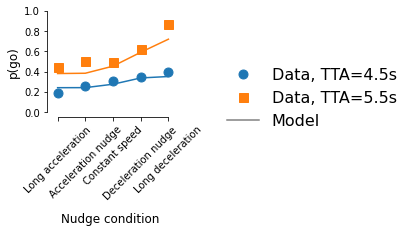

In [80]:
plot_var_by_condition(exp_measures, model_measures, var="is_go_decision", model_label=model_label,
                      include_model=True, include_legend=True)

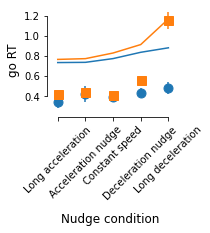

In [89]:
plot_var_by_condition(exp_measures, model_measures, var="RT_go", model_label=model_label, include_model=True)

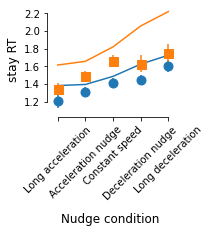

In [90]:
plot_var_by_condition(exp_measures, model_measures, var="RT_stay", model_label=model_label, include_model=True)

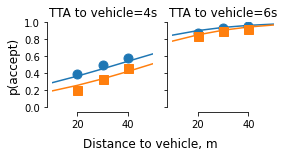

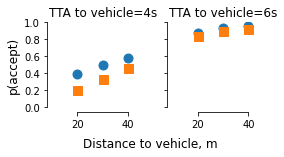

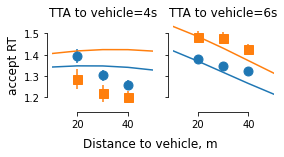

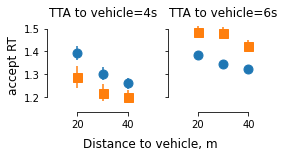

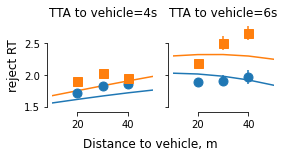

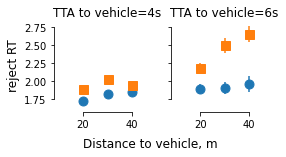

In [46]:
for var in ["is_gap_accepted", "RT_merge", "RT_wait"]:
    for include_model in [True, False]:
        plot_var_by_condition(exp_measures, model_measures, var=var, model_label=model_label, include_model=include_model)

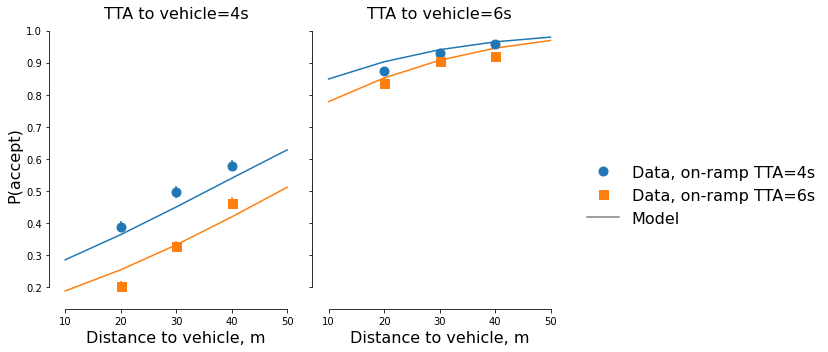

In [69]:
plot_var_by_condition(exp_measures, model_measures, var="is_gap_accepted", model_label=model_label, include_model=True)

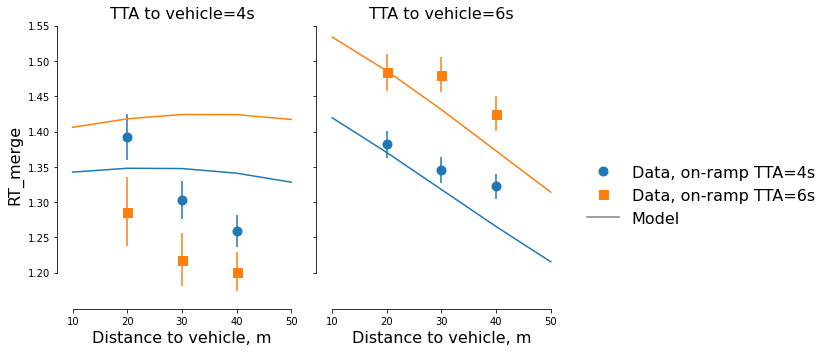

In [70]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label)

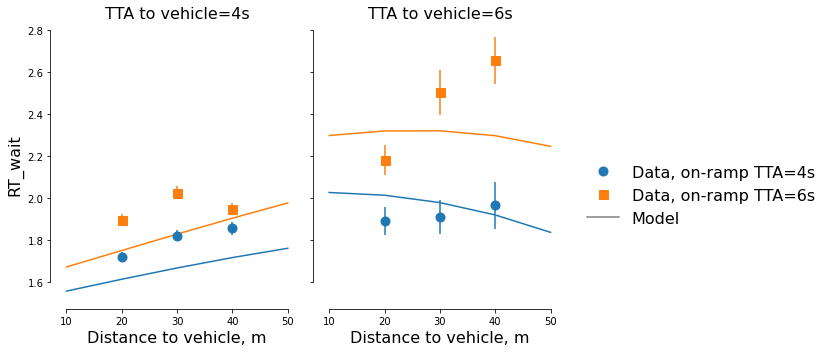

In [71]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label)

# Gaze-dependent drift & bound based on generalized gap

In [73]:
model_label="gaze_dependent_bound_generalized_gap_model"
model_measures = pd.read_csv("model_fit_results/%s/simulation_results/subj_all_measures.csv" % (model_label))

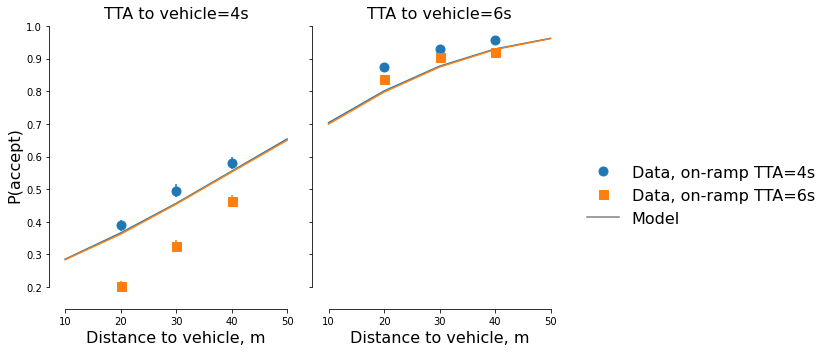

In [74]:
plot_var_by_condition(exp_measures, model_measures, var="is_gap_accepted", model_label=model_label)

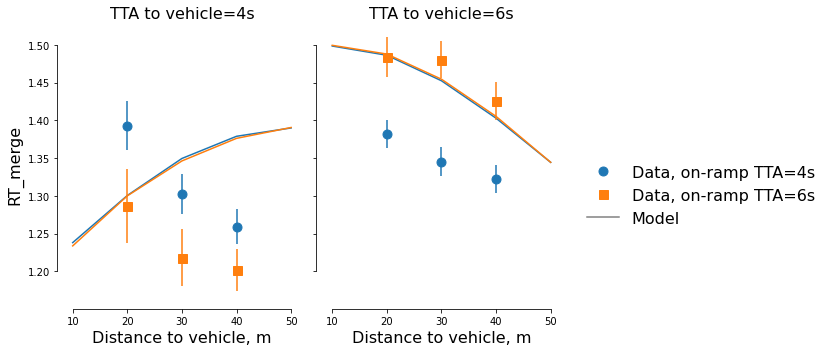

In [75]:
plot_var_by_condition(exp_measures, model_measures, var="RT_merge", model_label=model_label)

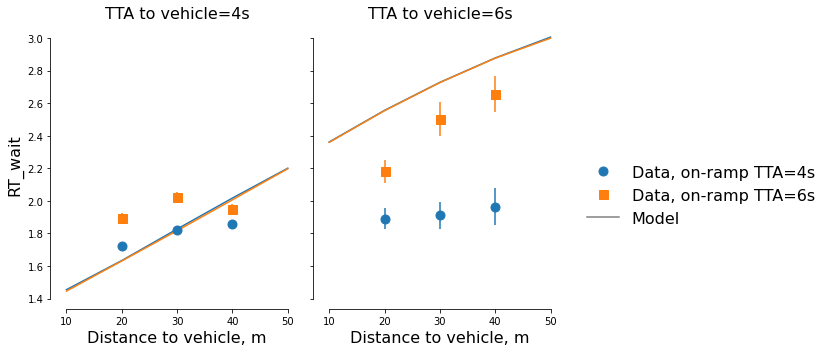

In [76]:
plot_var_by_condition(exp_measures, model_measures, var="RT_wait", model_label=model_label)

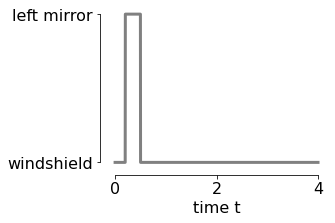

In [20]:
def get_gaze_sample(simulation_params):
    # In a typical trial, participants looked
    # 1) at the on-ramp for a short time - 300 ms
    # 2) at the mirror for 700 ms
    # 3) back at the on-ramp for the rest of the trial

    # return np.concatenate([np.zeros(int(0.2/simulation_params["dt"])), np.ones(int(1.0/simulation_params["dt"])),
    #                        np.zeros(int(0.1/simulation_params["dt"])), np.ones(int(0.2/simulation_params["dt"])),
    #                        np.zeros(int((simulation_params["duration"]-1.5)/simulation_params["dt"])+1)])

    return np.concatenate([np.zeros(int(0.2/simulation_params["dt"])), np.ones(int(0.3/simulation_params["dt"])),
                           np.zeros(int((simulation_params["duration"]-0.5)/simulation_params["dt"])+1)])

simulation_params = {"dt": 0.001, "duration": 4.0}

gaze_sample = get_gaze_sample(simulation_params)

plt.figure(figsize=(4, 3))
fontsize=16
plt.plot(np.linspace(0, simulation_params["duration"], len(gaze_sample)), gaze_sample, lw=3, color="grey")
ax = plt.gca()
ax.set_xlabel("time t", fontsize=fontsize)
ax.set_yticks([0, 1])
ax.set_yticklabels(["windshield", "left mirror"])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
sns.despine(offset=5, trim=True)
plt.savefig("output/gaze_sample_1.png", bbox_inches="tight")
